In [44]:
!pip install minisom
!pip install tslearn

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [45]:
# Native libraries
import os
import math
# Essential Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
# Algorithms
from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

In [46]:
directory = '/kaggle/input/retail-and-retailers-sales-time-series-collection/'

mySeries = []
namesofMySeries = []
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        df = pd.read_csv(directory+filename)
        df = df.loc[:,["date","value"]]
        # While we are at it I just filtered the columns that we will be working on
        df.set_index("date",inplace=True)
        # ,set the date columns as index
        df.sort_index(inplace=True)
        # and lastly, ordered the data according to our date index
        mySeries.append(df)
        namesofMySeries.append(filename[:-4])

Let's check how many series we have.

In [47]:
print(len(mySeries))

23


So, for 23 series let's create a 6 by 4 grid which will be resulted in 24 slots and fill it with the plot of our series.

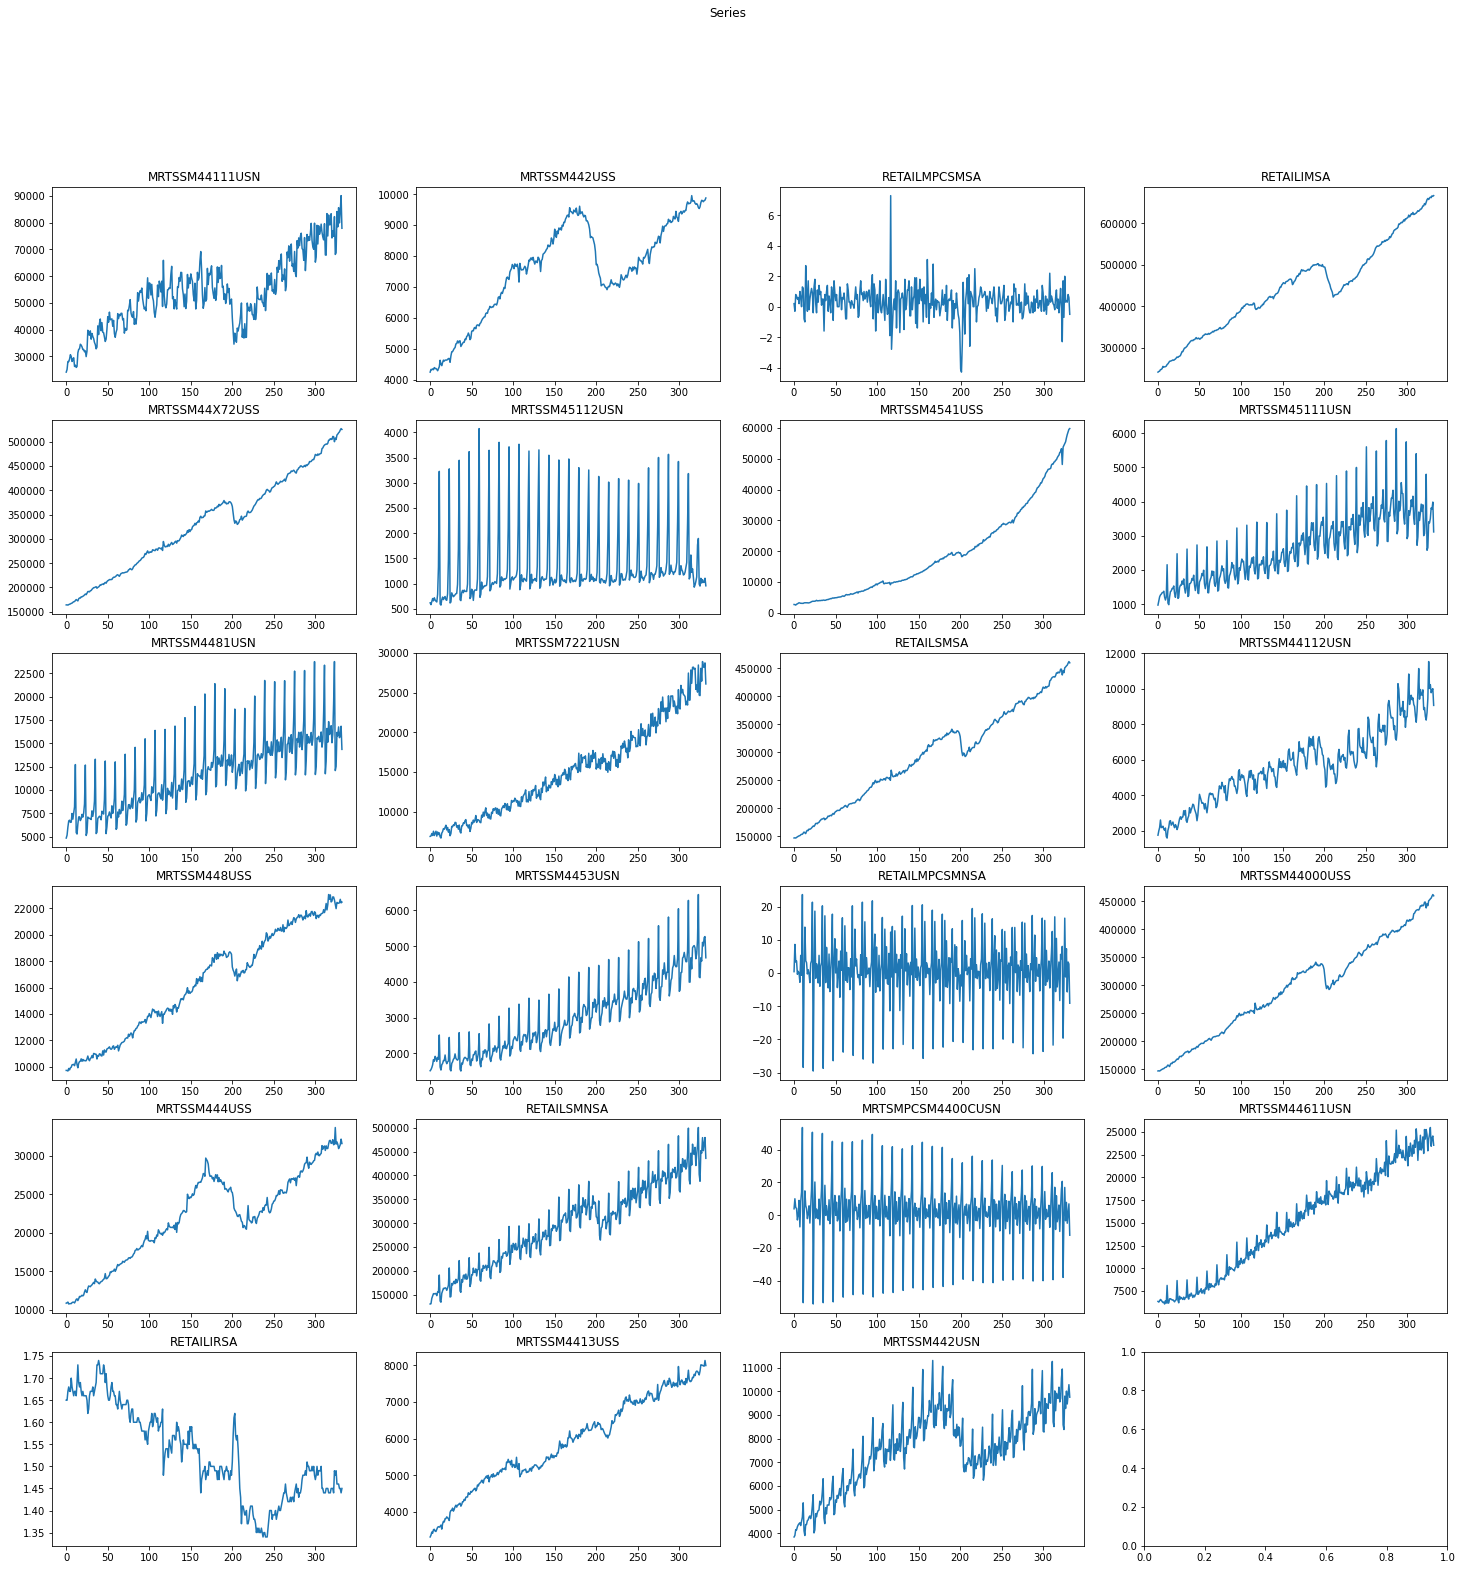

In [48]:
fig, axs = plt.subplots(6,4,figsize=(25,25))
fig.suptitle('Series')
for i in range(6):
    for j in range(4):
        if i*4+j+1>len(mySeries): # pass the others that we can't fill
            continue
        axs[i, j].plot(mySeries[i*4+j].values)
        axs[i, j].set_title(namesofMySeries[i*4+j])
plt.show()

It seems like there are pretty much similar time series such as ```MRTSSM44000USS``` and ```RETAILMSA``` or ```MRTSSM7221USN``` and ```MRTSSM44611USN```.

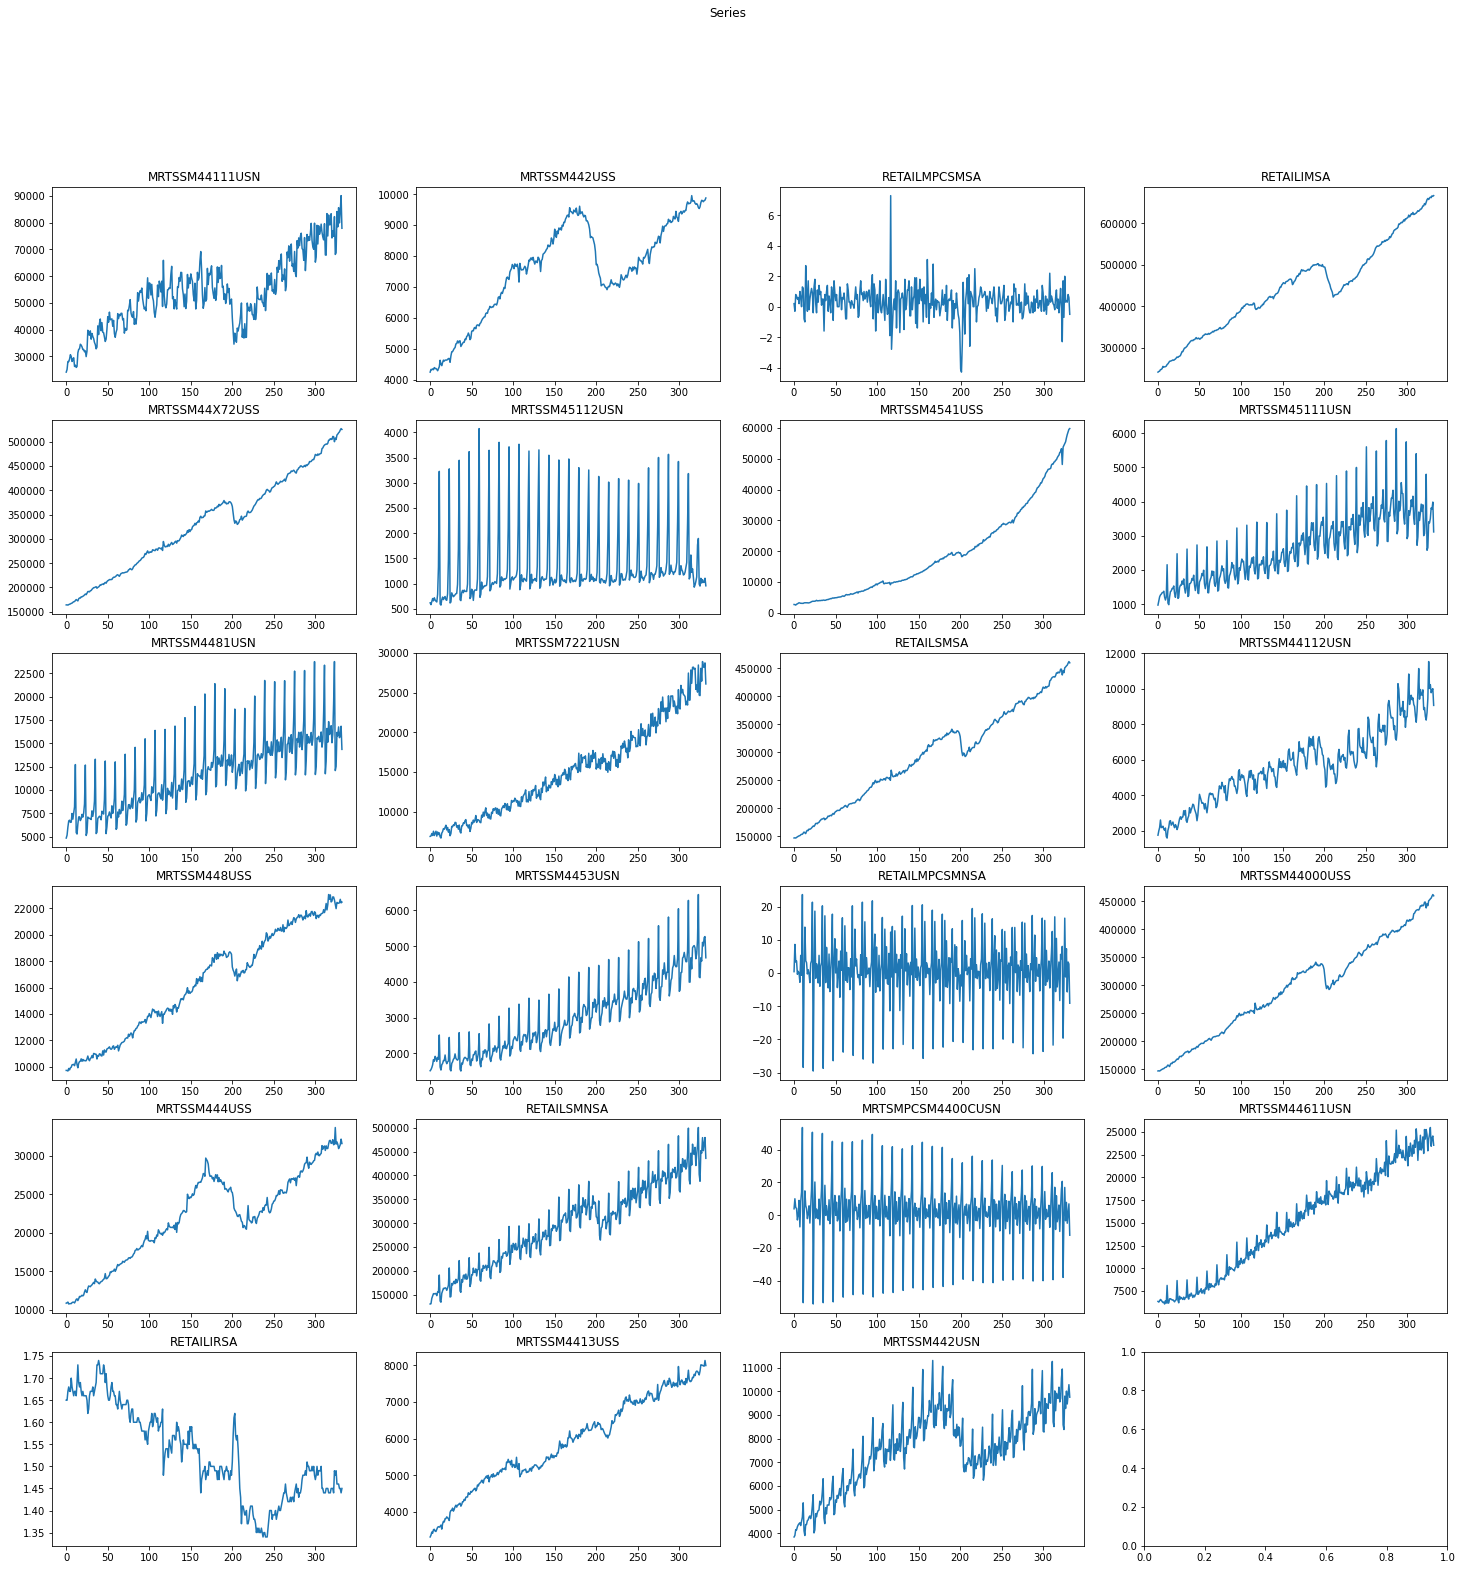

In [49]:
fig, axs = plt.subplots(6,4,figsize=(25,25))
fig.suptitle('Series')
for i in range(6):
    for j in range(4):
        if i*4+j+1>len(mySeries): # pass the others that we can't fill
            continue
        axs[i, j].plot(mySeries[i*4+j].values)
        axs[i, j].set_title(namesofMySeries[i*4+j])
plt.show()

## 2. 2. Preprocessing

Before we start analyzing let's check if our data is uniform in length.

In [50]:
series_lengths = {len(series) for series in mySeries}
print(series_lengths)

{332, 333}


As we guessed, it is not uniform in length. So in this case, we should find which series contain missing data and fill them. Because, otherwise our indices will be shifted and i.th index -let's say it is 10th of May- of the x series won't be same as i.th index of the y series -let's say i.th index of the y series may be 11th of May-.

In [51]:
ind = 0
for series in mySeries:
    print("["+str(ind)+"] "+series.index[0]+" "+series.index[len(series)-1])
    ind+=1

[0] 1992-01-01 2019-09-01
[1] 1992-01-01 2019-09-01
[2] 1992-02-01 2019-09-01
[3] 1992-01-01 2019-09-01
[4] 1992-01-01 2019-09-01
[5] 1992-01-01 2019-09-01
[6] 1992-01-01 2019-09-01
[7] 1992-01-01 2019-09-01
[8] 1992-01-01 2019-09-01
[9] 1992-01-01 2019-09-01
[10] 1992-01-01 2019-09-01
[11] 1992-01-01 2019-09-01
[12] 1992-01-01 2019-09-01
[13] 1992-01-01 2019-09-01
[14] 1992-02-01 2019-09-01
[15] 1992-01-01 2019-09-01
[16] 1992-01-01 2019-09-01
[17] 1992-01-01 2019-09-01
[18] 1992-02-01 2019-09-01
[19] 1992-01-01 2019-09-01
[20] 1992-01-01 2019-09-01
[21] 1992-01-01 2019-09-01
[22] 1992-01-01 2019-09-01


As you can see 6th, 11th and 12th series are not starting from the same date as others. To solve this problem, we should first find the longest series of the series and elongate others according to that. Usually, to do this we should check the oldest and newest date and elongate all series according to these dates. But in our case, nearly every series starts from 1992-01-01 and ends in 2019-09-01. Thus, finding the longest series will be enough for us.

In [52]:
max_len = max(series_lengths)
longest_series = None
for series in mySeries:
    if len(series) == max_len:
        longest_series = series

In this code block, I reindexed the series that are not as long as the longest one and fill the empty dates with ```np.nan```.

In [53]:
problems_index = []

for i in range(len(mySeries)):
    if len(mySeries[i])!= max_len:
        problems_index.append(i)
        mySeries[i] = mySeries[i].reindex(longest_series.index)

We can check how many series are polluted with nan values with this function.

In [54]:
def nan_counter(list_of_series):
    nan_polluted_series_counter = 0
    for series in list_of_series:
        if series.isnull().sum().sum() > 0:
            nan_polluted_series_counter+=1
    print(nan_polluted_series_counter)

We have 3 series that are polluted with nan and we used to have 3 series that are shorter than others, so math checks out.

In [55]:
nan_counter(mySeries)

3


Because these series lack only one point, I used linear interpolation to fill the gap but for series that have more missing value, you can use much more complex interpolation methods such as quadratic, cubic, spline, barycentric, etc.

In [56]:
for i in problems_index:
    mySeries[i].interpolate(limit_direction="both",inplace=True)

As we can see, now all of our series are the same length and don't contain any missing value.

In [57]:
nan_counter(mySeries)

0


After handling missing values, the other issue is the scale of the series. Without, normalizing data the series that looks like each other will be seen so different from each other and will affect the accuracy of the clustering process. We can see the effect of the normalizing in the following images.



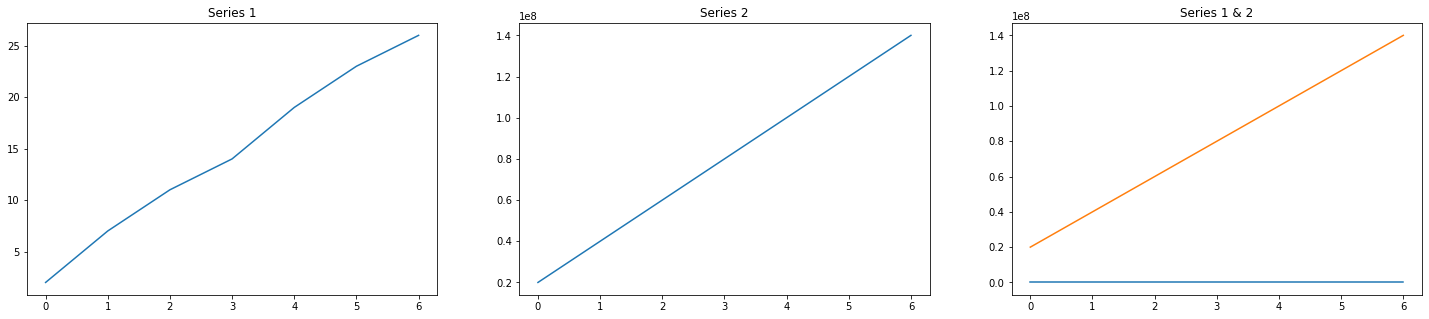

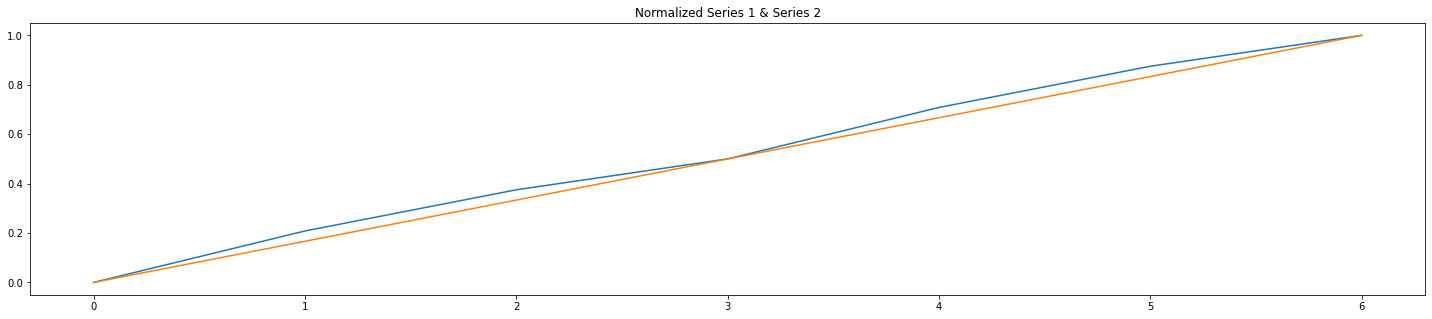

In [58]:
a = [[2],[7],[11],[14],[19],[23],[26]]
b = [[20000000],[40000000],[60000000],[80000000],[100000000],[120000000],[140000000]]
fig, axs = plt.subplots(1,3,figsize=(25,5))
axs[0].plot(a)
axs[0].set_title("Series 1")
axs[1].plot(b)
axs[1].set_title("Series 2")
axs[2].plot(a)
axs[2].plot(b)
axs[2].set_title("Series 1 & 2")
plt.figure(figsize=(25,5))
plt.plot(MinMaxScaler().fit_transform(a))
plt.plot(MinMaxScaler().fit_transform(b))
plt.title("Normalized Series 1 & Series 2")
plt.show()

Note that we normalized each time series by their own values, not the values of other time series.

In [59]:
for i in range(len(mySeries)):
    scaler = MinMaxScaler()
    mySeries[i] = MinMaxScaler().fit_transform(mySeries[i])
    mySeries[i]= mySeries[i].reshape(len(mySeries[i]))

The result of the normalizing process seems fine.

In [60]:
print("max: "+str(max(mySeries[0]))+"\tmin: "+str(min(mySeries[0])))
print(mySeries[0][:5])

max: 1.0	min: 0.0
[0.         0.01489761 0.05992317 0.05937869 0.07362594]


##  Clustering

I will be using 2 different methods for clustering these series. The first of the methods is Self Organizing Maps(SOM) and the other method is K-Means.

###  SOM
 
Self-organizing maps are a type of neural network that is trained using unsupervised learning to produce a low-dimensional representation of the input space of the training samples, called a map.

![SOM](https://raw.githubusercontent.com/izzettunc/Kohonen-SOM/master/data/screenshots/landing.png)
<center>Source : Github Repo: <a href="https://raw.githubusercontent.com/izzettunc/Kohonen-SOM/master/data/screenshots/landing.png">landing.png</a></center>
<br>    
Also, self-organizing maps  differ from other artificial neural networks as they apply competitive(or cooperative) learning as opposed to error-correction learning (such as backpropagation with gradient descent), and in the sense that they use a neighborhood function to preserve the topological properties of the input space.

![Learning process of som](https://upload.wikimedia.org/wikipedia/commons/3/35/TrainSOM.gif)
<center>Source : Wiki Commons: <a href="https://upload.wikimedia.org/wikipedia/commons/3/35/TrainSOM.gif">TrainSOM.gif</a></center>
<br>
Because of the ability to produce a map, som deemed as a method to do dimensionality reduction. But in our case, when each node of the som is accepted as medoids of the cluster, we can use it for clustering. To do so, we should remove our time indices from our time series, and instead of measured values of each date, we should accept them as different features and dimensions of a single data point.

For more info about some, you can check [this medium post](https://medium.com/@abhinavr8/self-organizing-maps-ff5853a118d4).

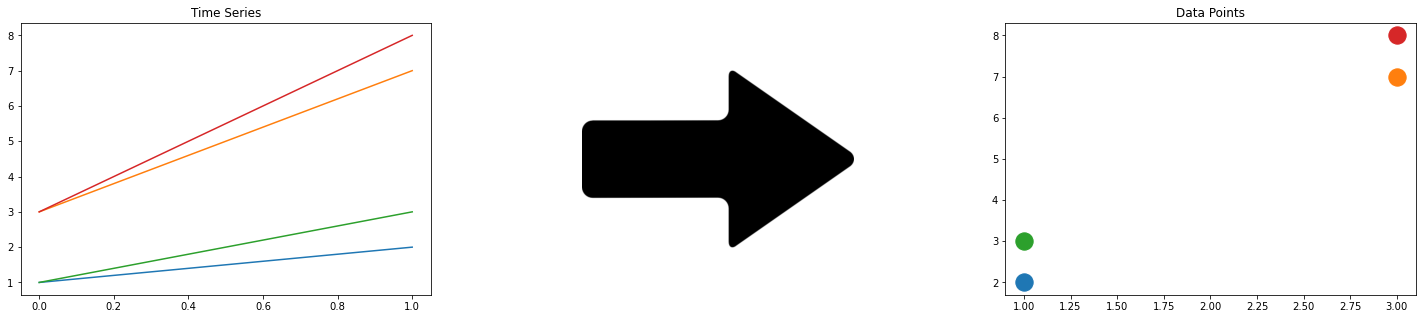

In [61]:
a = [1,2]
b = [3,7]
c = [1,3]
d = [3,8]
img = plt.imread("/kaggle/input/notebook-material/arrow.png")
fig, axs = plt.subplots(1,3,figsize=(25,5))
axs[0].plot(a)
axs[0].plot(b)
axs[0].plot(c)
axs[0].plot(d)
axs[0].set_title("Time Series")
axs[1].imshow(img)
axs[1].axis("off")
axs[2].set_title("Data Points")
axs[2].scatter(a[0],a[1], s=300)
axs[2].scatter(b[0],b[1], s=300)
axs[2].scatter(c[0],c[1], s=300)
axs[2].scatter(d[0],d[1], s=300)
plt.show()

For the implementation of the som algorithm I used [miniSom](https://github.com/JustGlowing/minisom) and set my parameters as follows:
- sigma: 0.3
- learning_rate: 0.5
- random weight initialization
- 50.000 iteration
- Map size: square root of the number of series

As a side note, I didn't optimize these parameters due to the simplicity of the dataset.

In [62]:
som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(mySeries))))
# I didn't see its significance but to make the map square,
# I calculated square root of map size which is 
# the square root of the number of series
# for the row and column counts of som

som = MiniSom(som_x, som_y,len(mySeries[0]), sigma=0.3, learning_rate = 0.1)

som.random_weights_init(mySeries)
som.train(mySeries, 50000)


####  Results

After the training, I plotted the results. For each cluster, I plotted every series, a little bit transparent and in gray, and in order to see the movement or the shape of the cluster, I took the average of the cluster and plotted that averaged series in red .

In [63]:
# Little handy function to plot series
def plot_som_series_averaged_center(som_x, som_y, win_map):
    fig, axs = plt.subplots(som_x,som_y,figsize=(25,25))
    fig.suptitle('Clusters')
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x,y)
            if cluster in win_map.keys():
                for series in win_map[cluster]:
                    axs[cluster].plot(series,c="gray",alpha=0.5) 
                axs[cluster].plot(np.average(np.vstack(win_map[cluster]),axis=0),c="red")
            cluster_number = x*som_y+y+1
            axs[cluster].set_title(f"Cluster {cluster_number}")

    plt.show()

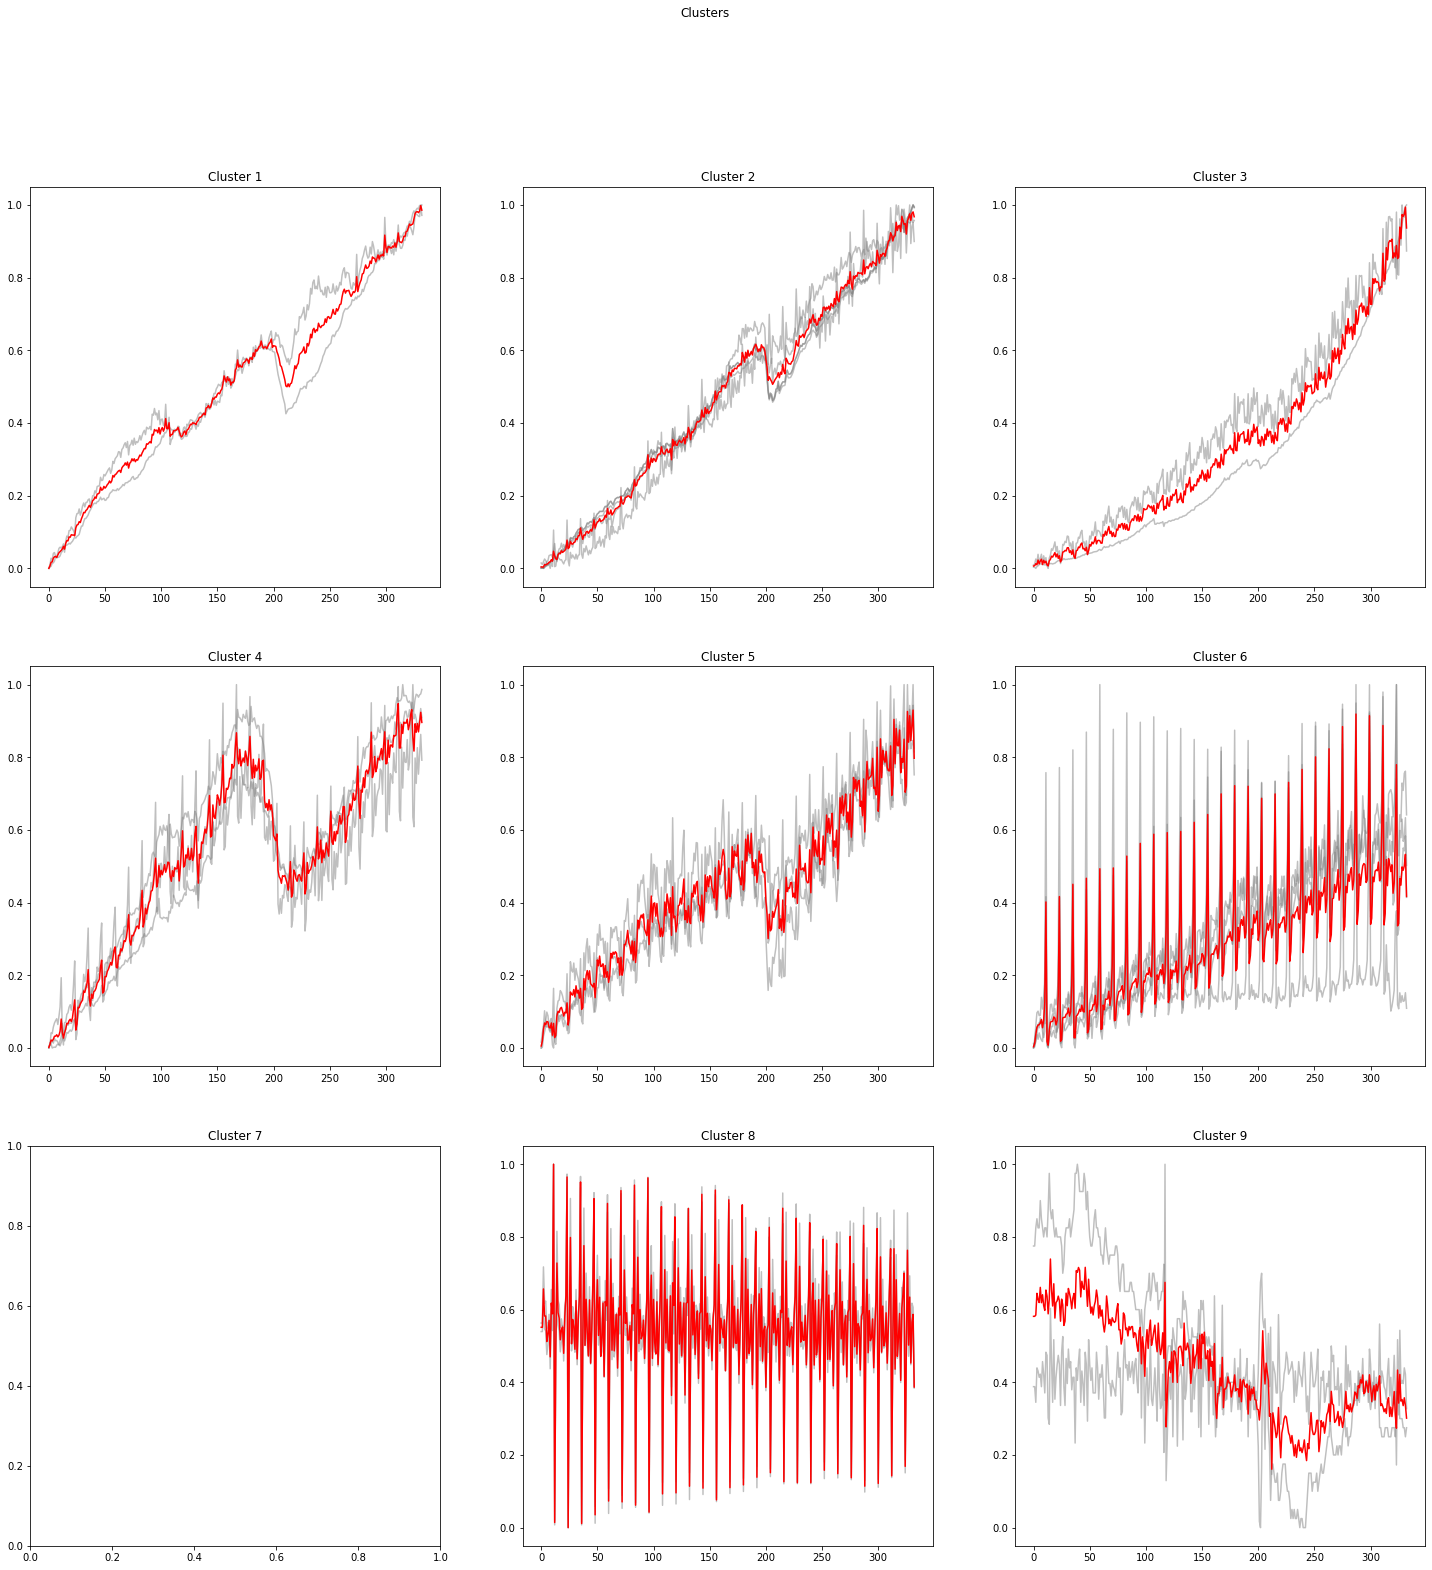

In [64]:
win_map = som.win_map(mySeries)
# Returns the mapping of the winner nodes and inputs

plot_som_series_averaged_center(som_x, som_y, win_map)

As you can see from the plot below, som perfectly clustered the 23 different series into 8 clusters.

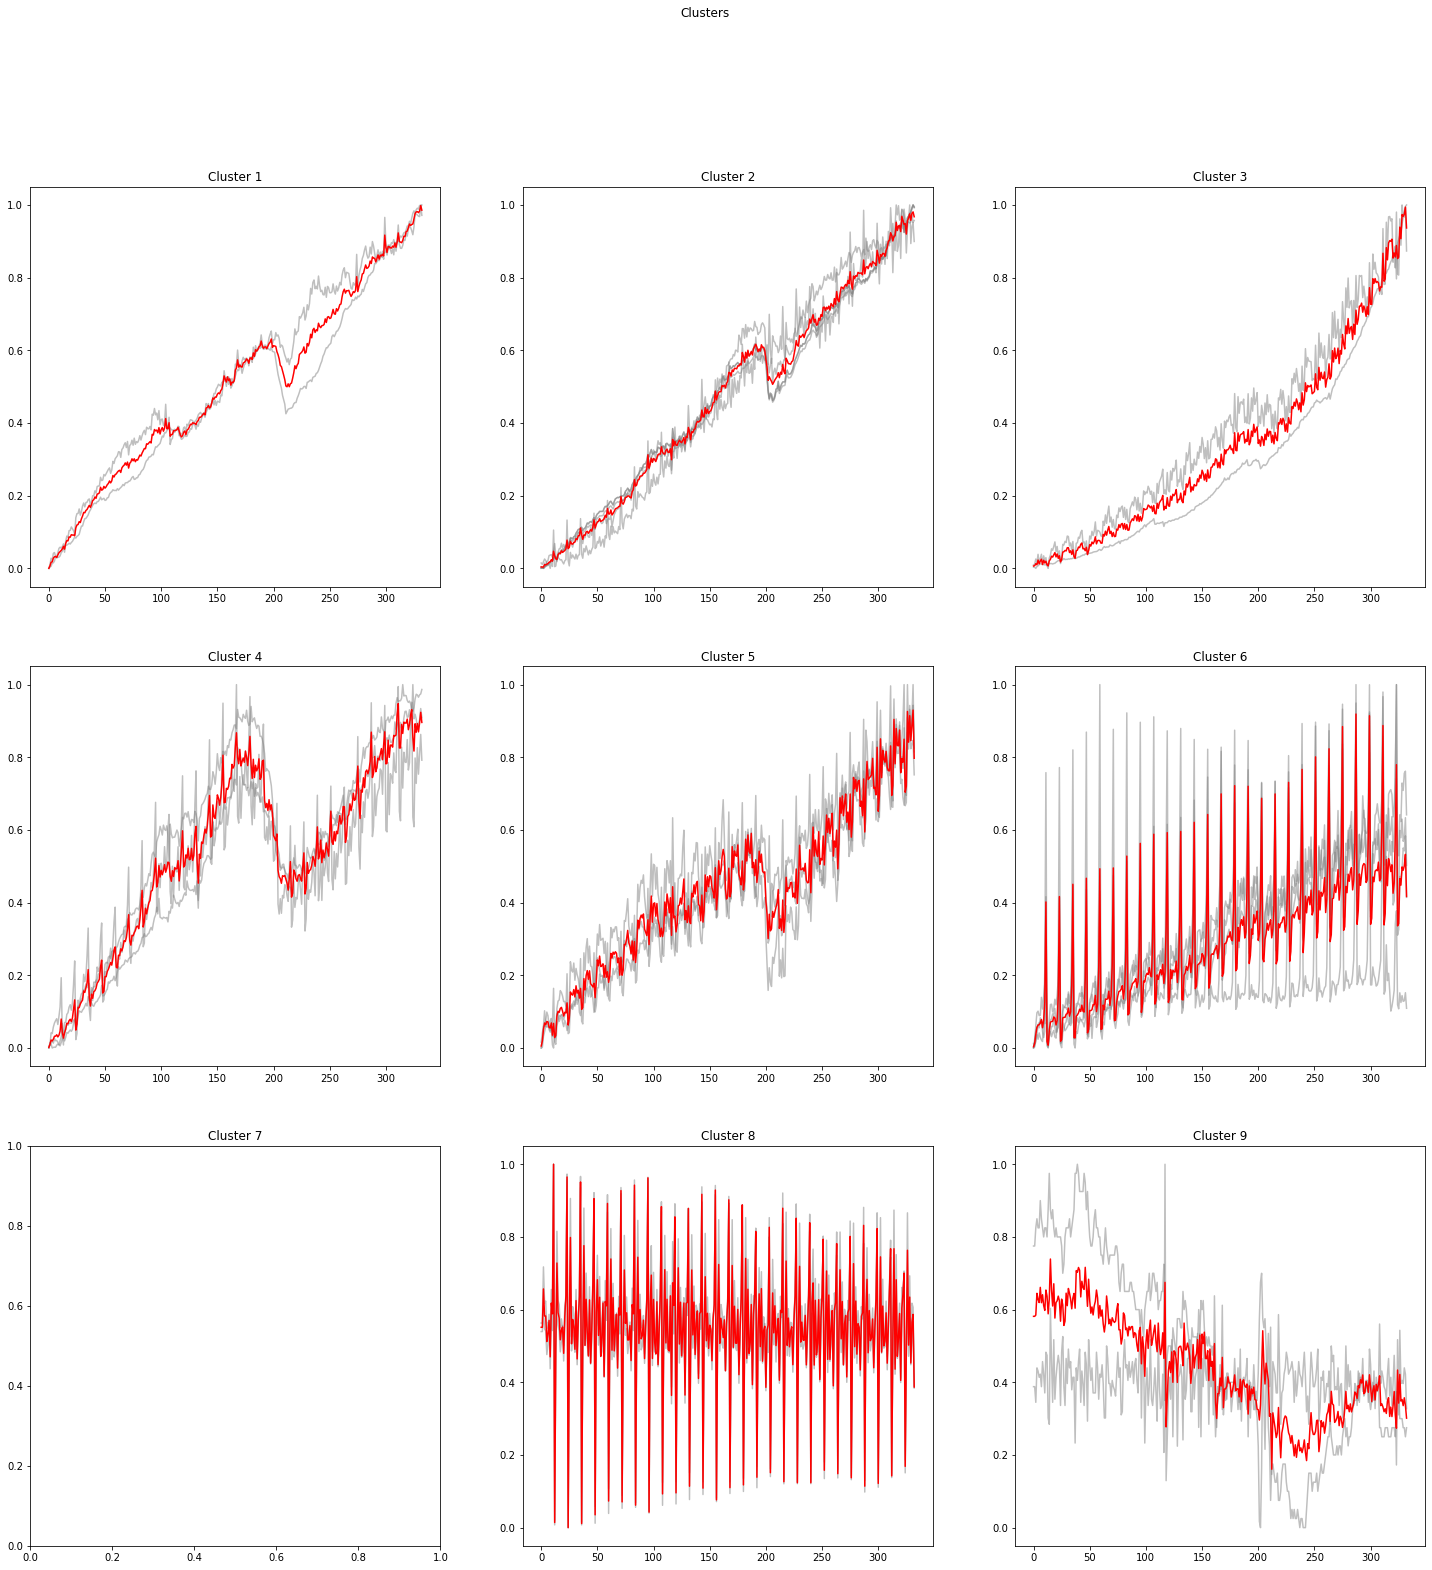

In [65]:
win_map = som.win_map(mySeries)
# Returns the mapping of the winner nodes and inputs

plot_som_series_averaged_center(som_x, som_y, win_map)

In [66]:
def plot_som_series_dba_center(som_x, som_y, win_map):
    fig, axs = plt.subplots(som_x,som_y,figsize=(25,25))
    fig.suptitle('Clusters')
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x,y)
            if cluster in win_map.keys():
                for series in win_map[cluster]:
                    axs[cluster].plot(series,c="gray",alpha=0.5) 
                axs[cluster].plot(dtw_barycenter_averaging(np.vstack(win_map[cluster])),c="red") # I changed this part
            cluster_number = x*som_y+y+1
            axs[cluster].set_title(f"Cluster {cluster_number}")

    plt.show()

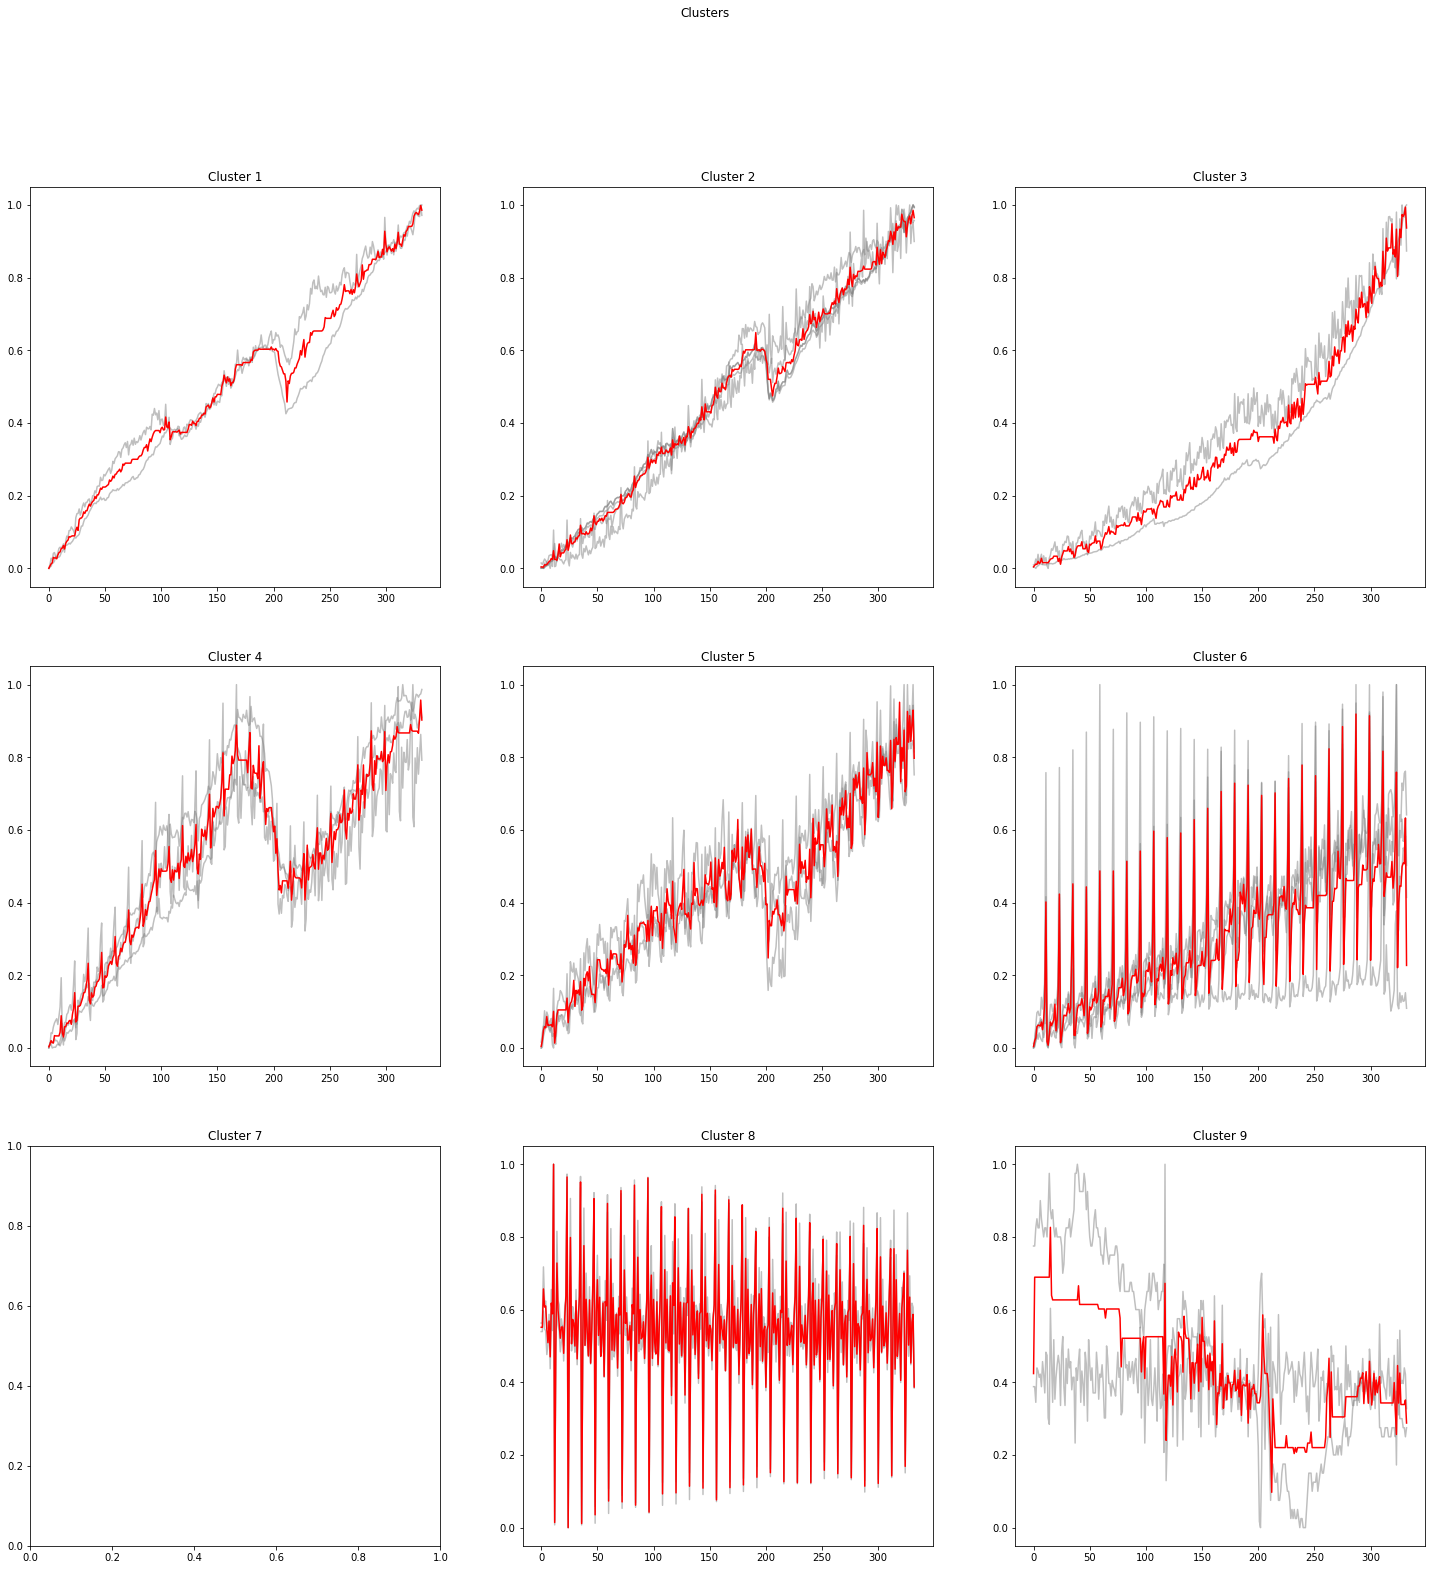

In [67]:
win_map = som.win_map(mySeries)

plot_som_series_dba_center(som_x, som_y, win_map)

We can't see much difference from this result but, I highly recommend that to use this method for this purpose. But, also, note that the operation of dba is not a light one. So, if you seek speed, this method might not be for you.

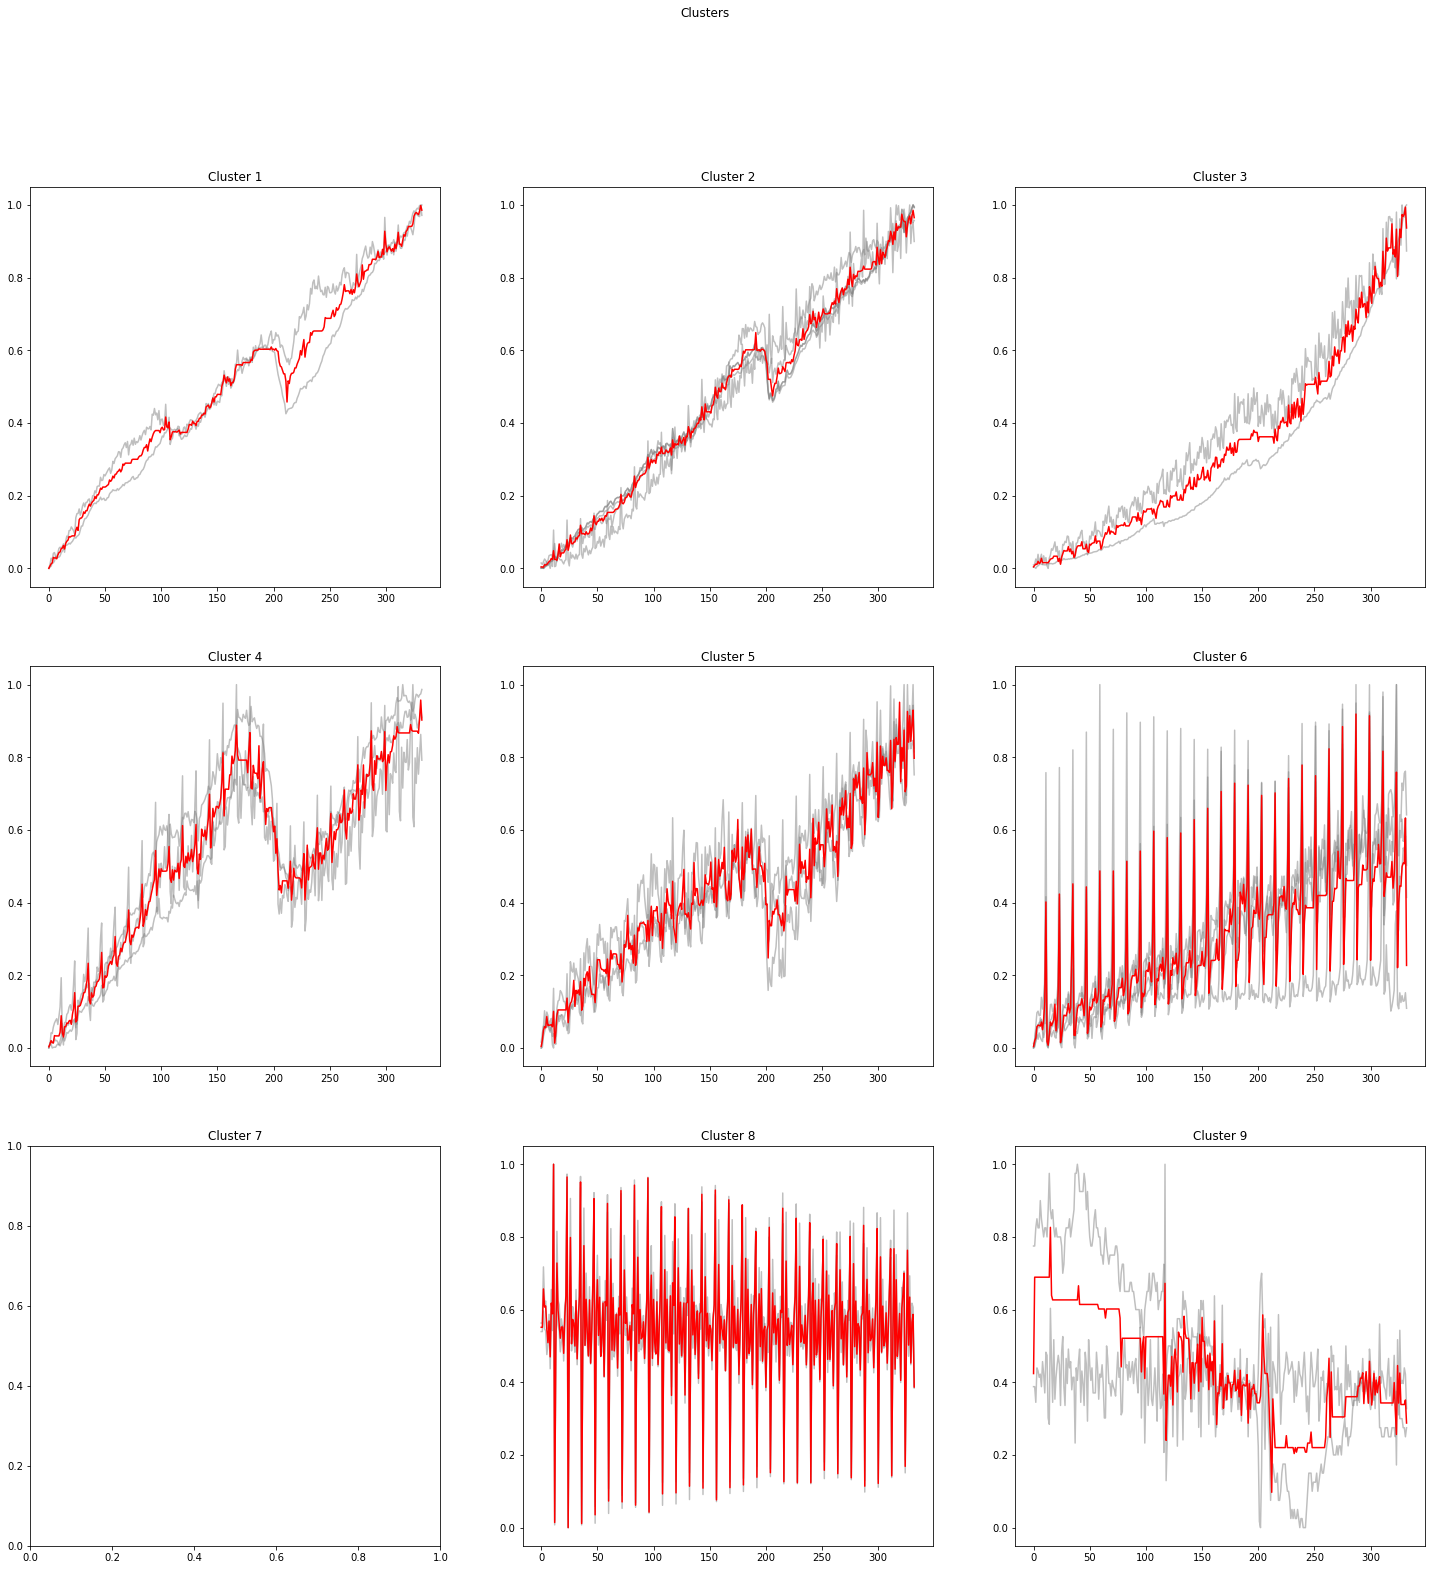

In [68]:
win_map = som.win_map(mySeries)

plot_som_series_dba_center(som_x, som_y, win_map)

#### 2. 3. 1. 2. Cluster Distribution
We can see the distribution of the time series in clusters in the following chart.

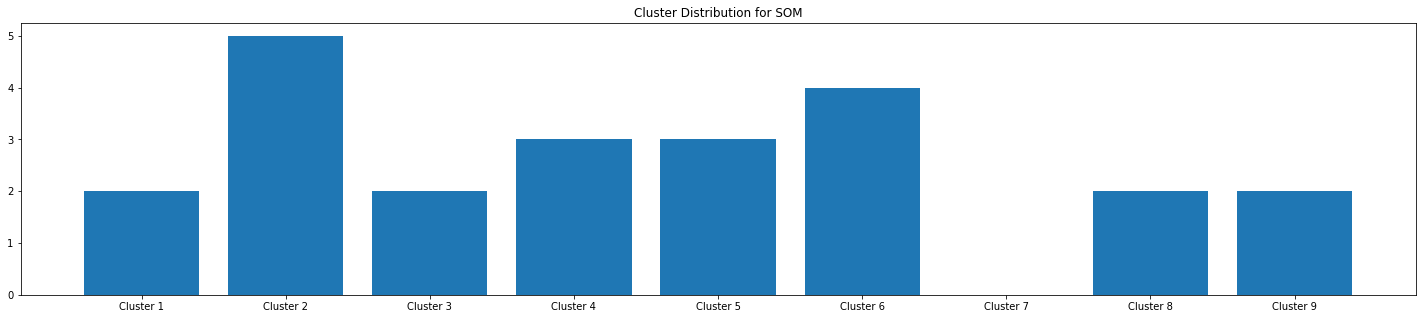

In [69]:
cluster_c = []
cluster_n = []
for x in range(som_x):
    for y in range(som_y):
        cluster = (x,y)
        if cluster in win_map.keys():
            cluster_c.append(len(win_map[cluster]))
        else:
            cluster_c.append(0)
        cluster_number = x*som_y+y+1
        cluster_n.append(f"Cluster {cluster_number}")

plt.figure(figsize=(25,5))
plt.title("Cluster Distribution for SOM")
plt.bar(cluster_n,cluster_c)
plt.show()

#### Cluster Mapping

Well, we did cluster our series but how de we know which series belonging to which cluster? Ain't that the whole purpose of clustering? <br><br>

As we can see in [these illustrations](#2.-3.-1.-SOM) each node (or multiple of nodes in some cases) represents a cluster. Therefore we can find out which series is belonging to which cluster by checking the winner node of each series. 

In [70]:
# Let's check first 5
for series in mySeries[:5]:
    print(som.winner(series))

(1, 1)
(1, 0)
(2, 2)
(0, 0)
(0, 1)


In order to make this piece of information more appealing to eye, we can map each node to a number <br>

```e.g. for n*m grid (0,0)=1, (0,1)=2, ... (0,m)=m+1, (1,0)=(m+1)+1, (1,1)=(m+1)+2, ... , (n,m)=(n+1)*(m+1) ``` 

and print the name of the series with the cluster number.

In [71]:
cluster_map = []
for idx in range(len(mySeries)):
    winner_node = som.winner(mySeries[idx])
    cluster_map.append((namesofMySeries[idx],f"Cluster {winner_node[0]*som_y+winner_node[1]+1}"))

pd.DataFrame(cluster_map,columns=["Series","Cluster"]).sort_values(by="Cluster").set_index("Series")

Cluster
Series                      
RETAILIMSA         Cluster 1
MRTSSM4413USS      Cluster 1
MRTSSM44611USN     Cluster 2
MRTSSM44X72USS     Cluster 2
MRTSSM44000USS     Cluster 2
RETAILSMSA         Cluster 2
MRTSSM448USS       Cluster 2
MRTSSM4541USS      Cluster 3
MRTSSM7221USN      Cluster 3
MRTSSM442USN       Cluster 4
MRTSSM442USS       Cluster 4
MRTSSM444USS       Cluster 4
RETAILSMNSA        Cluster 5
MRTSSM44111USN     Cluster 5
MRTSSM44112USN     Cluster 5
MRTSSM4481USN      Cluster 6
MRTSSM45111USN     Cluster 6
MRTSSM45112USN     Cluster 6
MRTSSM4453USN      Cluster 6
RETAILMPCSMNSA     Cluster 8
MRTSMPCSM4400CUSN  Cluster 8
RETAILMPCSMSA      Cluster 9
RETAILIRSA         Cluster 9

In [72]:
cluster_count = math.ceil(math.sqrt(len(mySeries))) 
# A good rule of thumb is choosing k as the square root of the number of points in the training data set in kNN

km = TimeSeriesKMeans(n_clusters=cluster_count, metric="dtw")

labels = km.fit_predict(mySeries)

#### Results

After the training, I plotted the results as I did with the som. For each cluster, I plotted every series, a little bit transparent and in gray, and in order to see the movement or the shape of the cluster, I took the average of the cluster and plotted that averaged series in red.

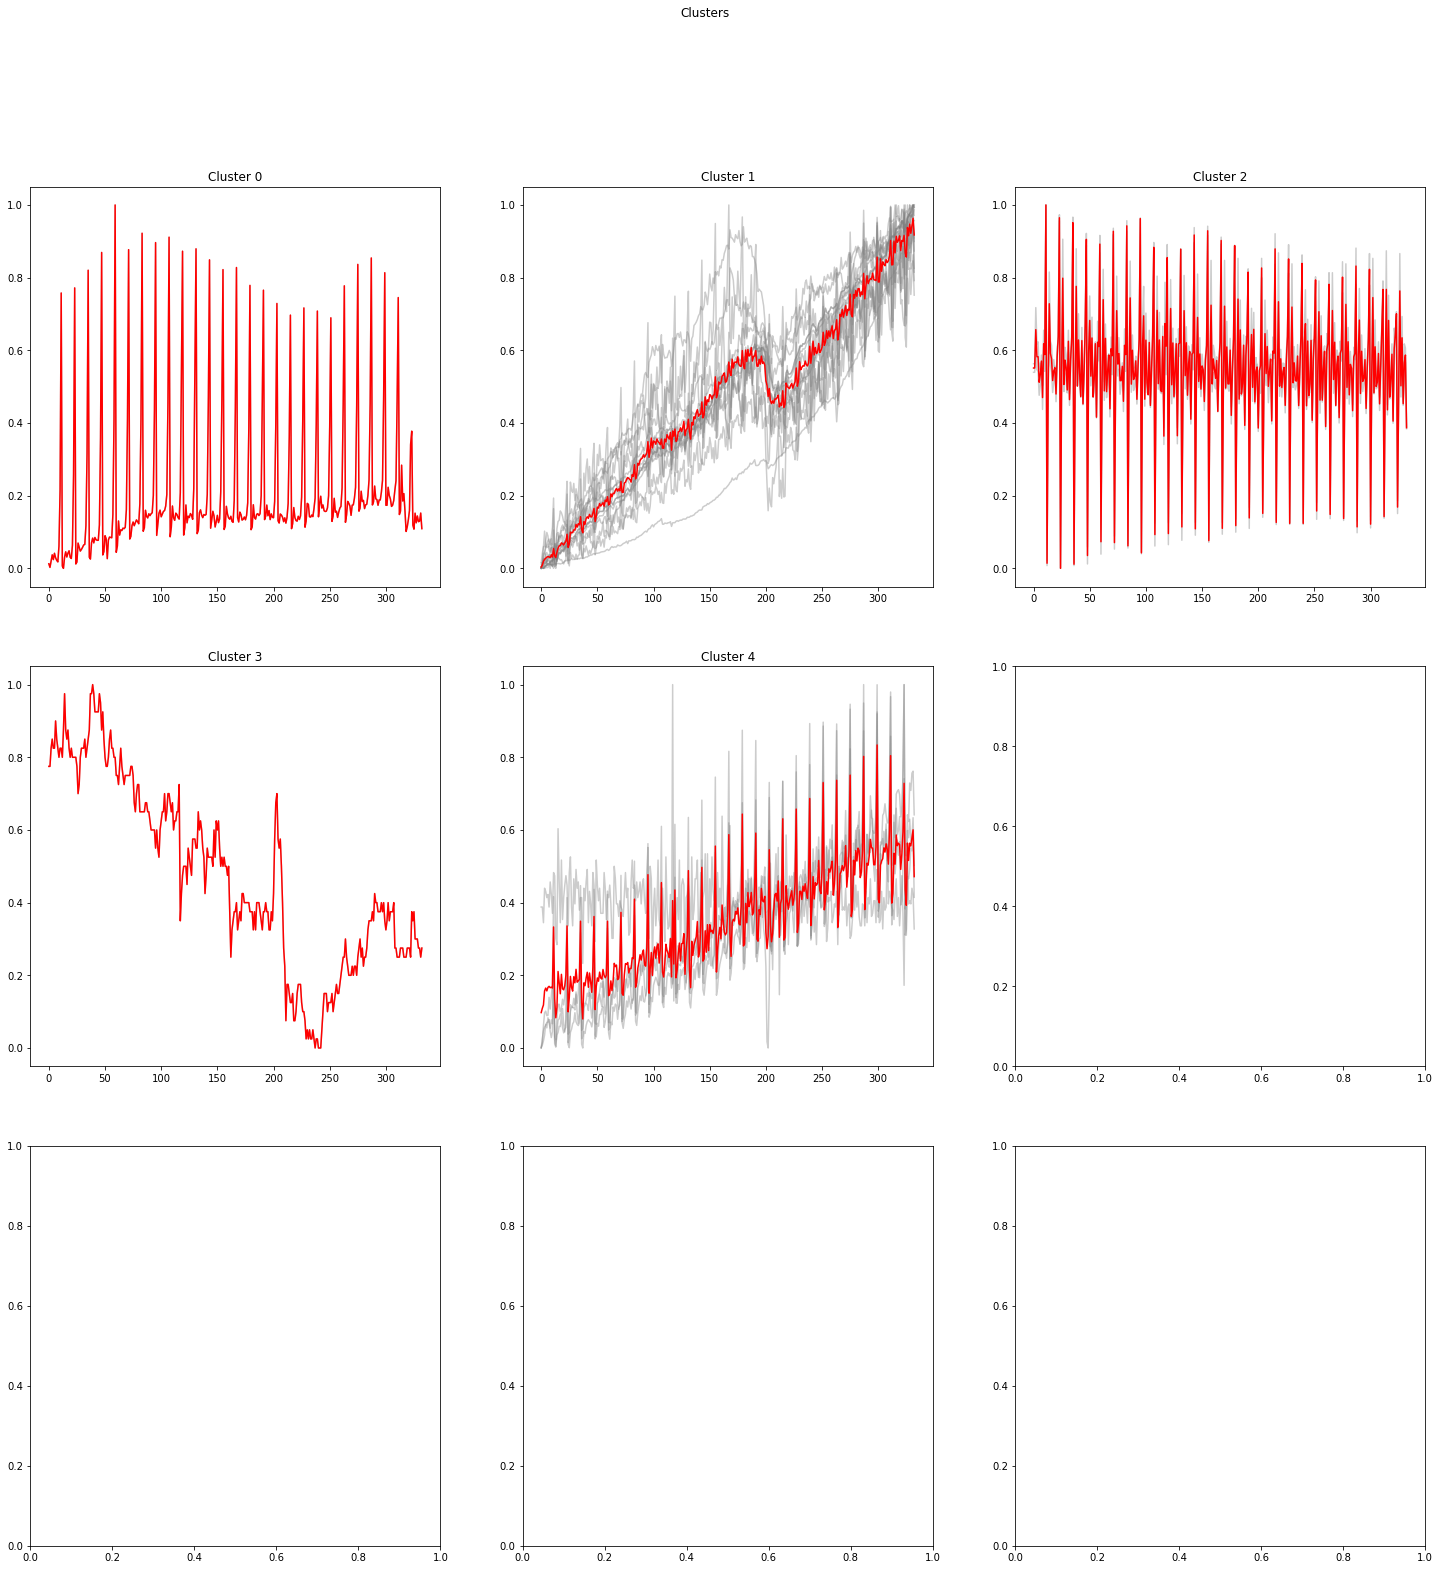

In [73]:
plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0
# For each label there is,
# plots every series with that label
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(mySeries[i],c="gray",alpha=0.4)
                cluster.append(mySeries[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()

As you can see from the plot below, k-means clustered the 23 different series into 5 clusters. 2 of the clusters contains only 1 time series which may be deemed as an outlier.

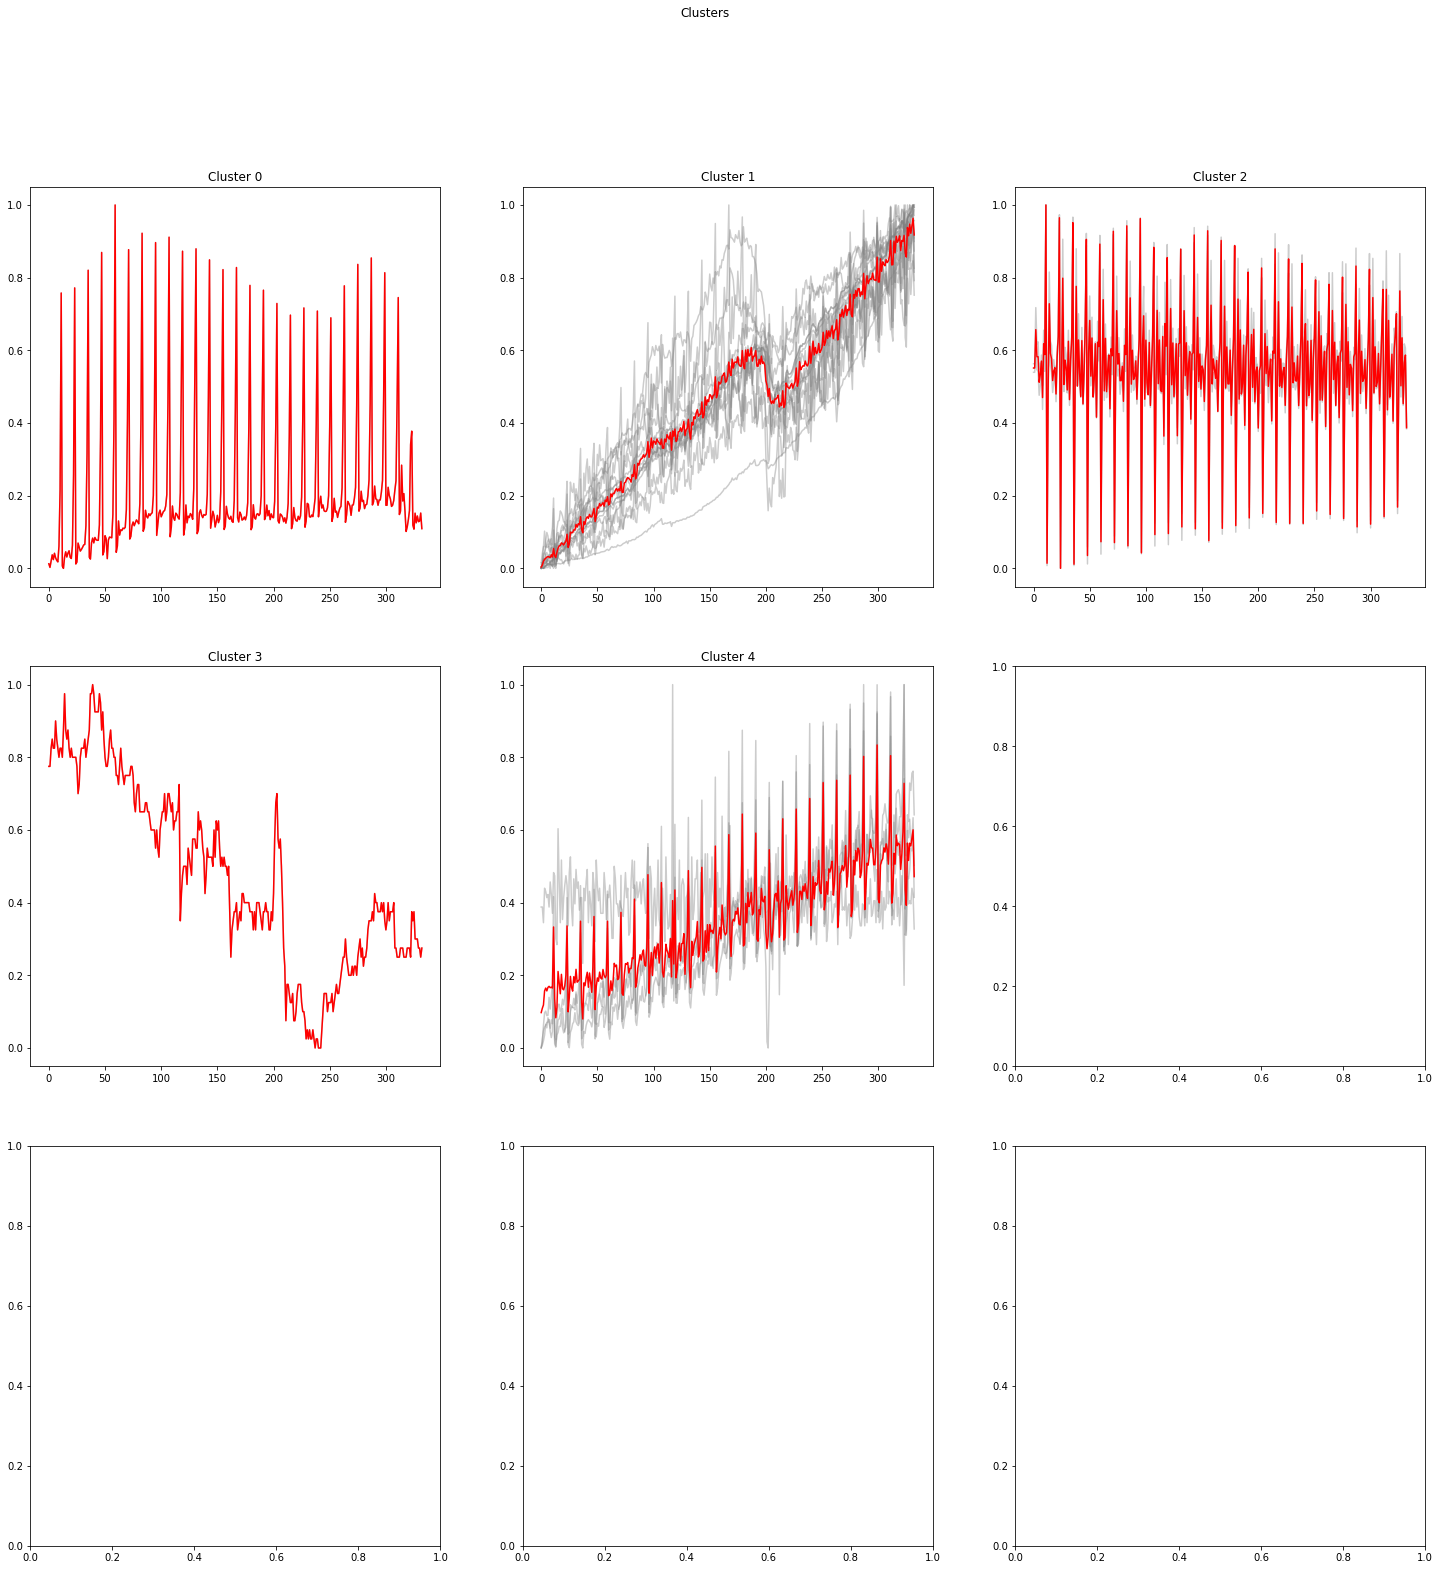

In [74]:
plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0
# For each label there is,
# plots every series with that label
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(mySeries[i],c="gray",alpha=0.4)
                cluster.append(mySeries[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()

As I did before, I used [DBA](https://github.com/fpetitjean/DBA) to see much more time dilated series.

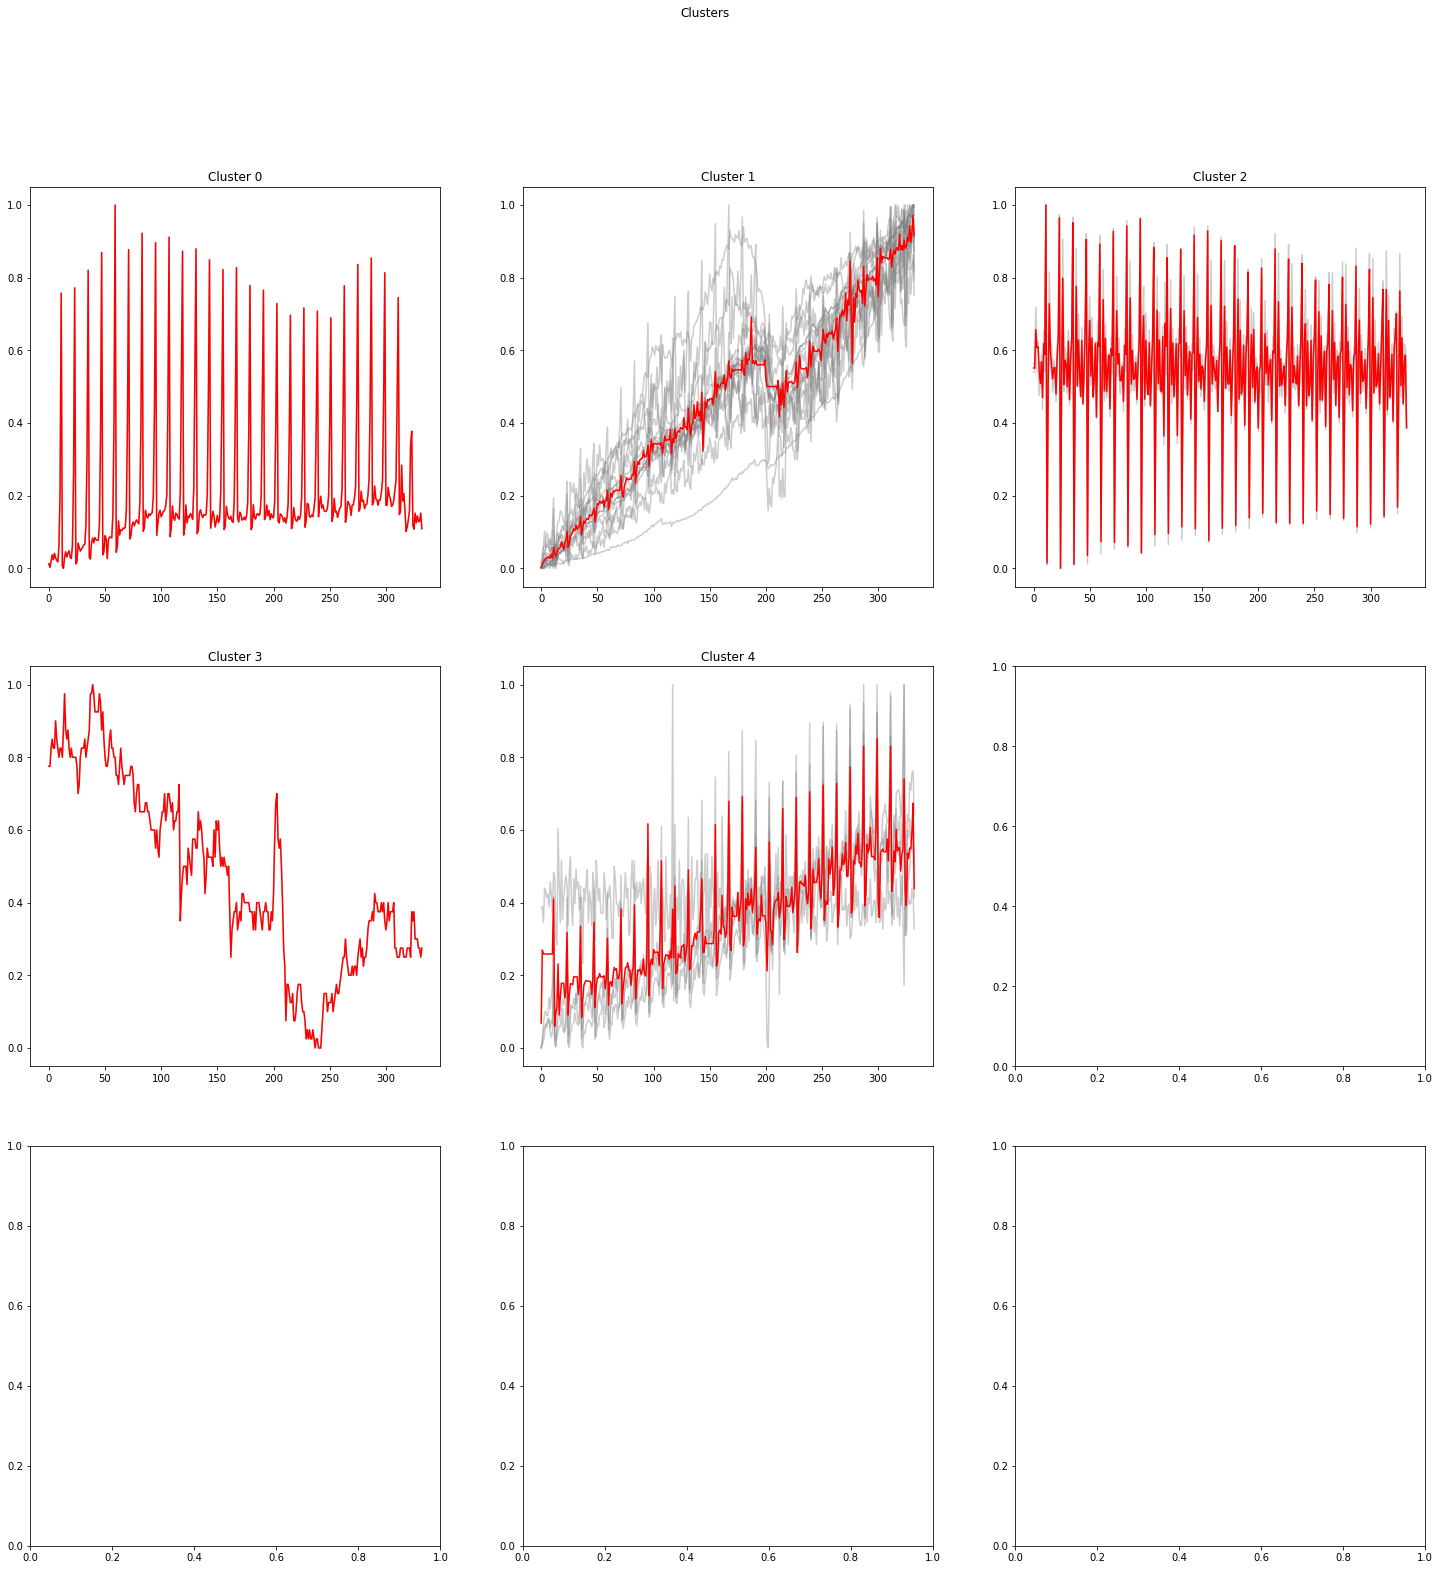

In [75]:
plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(mySeries[i],c="gray",alpha=0.4)
                cluster.append(mySeries[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(dtw_barycenter_averaging(np.vstack(cluster)),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()

#### 2. 3. 2. 2. Cluster Distribution

We can see the distribution of the time series in clusters in the following chart. And it seems like k-means clustered 15 of the time series as cluster 1, which is a bit skewed. The reason why this happens is the most probably ```The Curse of Dimentionality``` <p><small><small>You can check it out from the links that I provided at section 5 (See Also)</small></small></p>


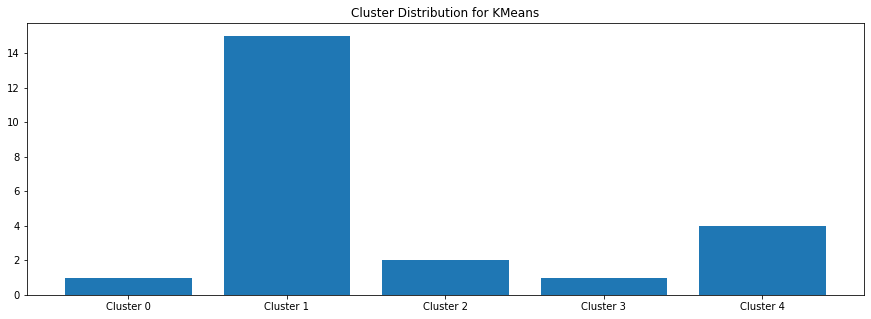

In [76]:
cluster_c = [len(labels[labels==i]) for i in range(cluster_count)]
cluster_n = ["Cluster "+str(i) for i in range(cluster_count)]
plt.figure(figsize=(15,5))
plt.title("Cluster Distribution for KMeans")
plt.bar(cluster_n,cluster_c)
plt.show()

####  Cluster Mapping

As we did before, in this part we will be finding which series belonging to which cluster. Thanks to awesome scikit-learn library we actually already have that information. Order of the labels is the same order with our series.


In [77]:
labels

array([1, 1, 4, 1, 1, 0, 1, 4, 4, 1, 1, 1, 1, 4, 2, 1, 1, 1, 2, 1, 3, 1,
       1])

In [78]:
fancy_names_for_labels = [f"Cluster {label}" for label in labels]
pd.DataFrame(zip(namesofMySeries,fancy_names_for_labels),columns=["Series","Cluster"]).sort_values(by="Cluster").set_index("Series")

Cluster
Series                      
MRTSSM45112USN     Cluster 0
MRTSSM44111USN     Cluster 1
MRTSSM44611USN     Cluster 1
RETAILSMNSA        Cluster 1
MRTSSM444USS       Cluster 1
MRTSSM44000USS     Cluster 1
MRTSSM448USS       Cluster 1
MRTSSM4413USS      Cluster 1
RETAILSMSA         Cluster 1
MRTSSM44112USN     Cluster 1
MRTSSM4541USS      Cluster 1
MRTSSM44X72USS     Cluster 1
RETAILIMSA         Cluster 1
MRTSSM442USS       Cluster 1
MRTSSM7221USN      Cluster 1
MRTSSM442USN       Cluster 1
RETAILMPCSMNSA     Cluster 2
MRTSMPCSM4400CUSN  Cluster 2
RETAILIRSA         Cluster 3
MRTSSM4481USN      Cluster 4
MRTSSM45111USN     Cluster 4
MRTSSM4453USN      Cluster 4
RETAILMPCSMSA      Cluster 4

####  Curse of Dimensionality

Curse of Dimensionality is a term, first invented by Richard E. Bellman when considering problems in dynamic programming. It basically means, when the dimensionality of the data increase so does the distance between data points. Thus, this change in measurement of distance affects the distance-based algorithms badly. To learn for more about it please check section [5. See Also](#5.-See-Also).

To solve this problem there are numerous algorithms that can be helpful such as PCA which is the most prominent of them, t-SNE, UMAP(map of the som), etc.

In [79]:
pca = PCA(n_components=2)

mySeries_transformed = pca.fit_transform(mySeries)

Now with less dimension than before, we can see how our series distributed in 2 dimensions.

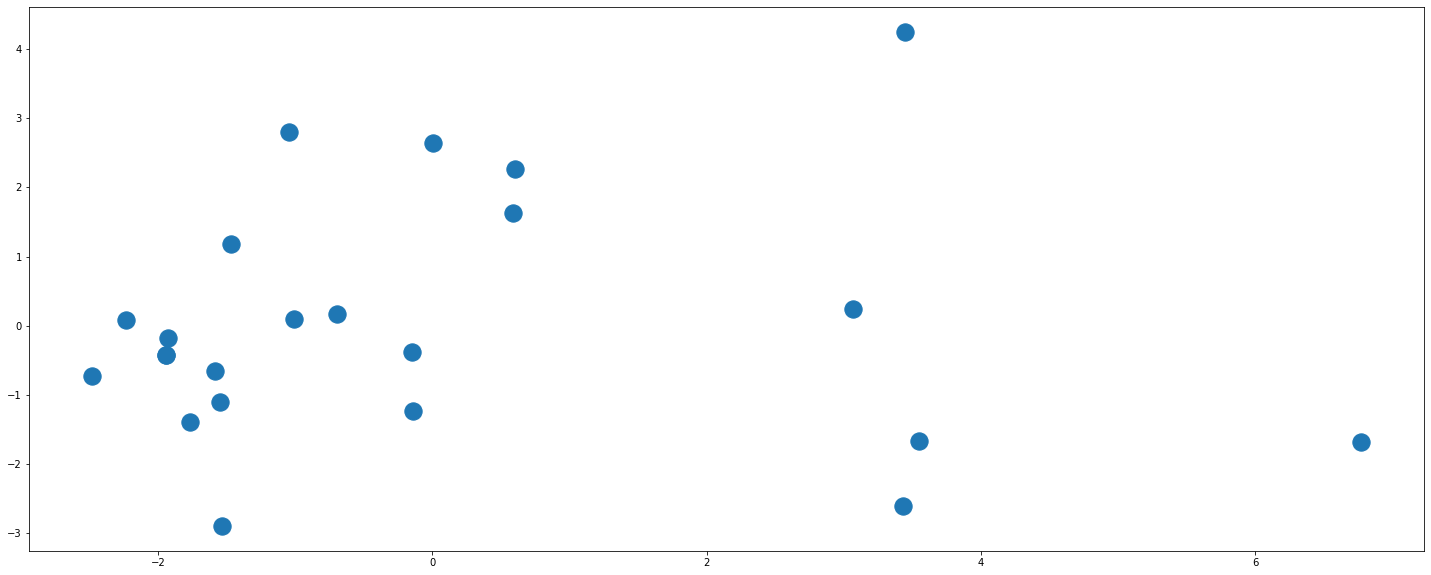

In [80]:
plt.figure(figsize=(25,10))
plt.scatter(mySeries_transformed[:,0],mySeries_transformed[:,1], s=300)
plt.show()

The result of PCA is basically, representation of a 333-dimensional data point as a 2-dimensional data point. As a result of that instead of a time series, we have just 2 value for each series.

In [81]:
print(mySeries_transformed[0:5])

[[-0.14827418 -0.38116355]
 [-1.53359961 -2.89464724]
 [ 3.06449901  0.24096143]
 [-1.58254491 -0.65803444]
 [-1.92616868 -0.18032212]]


Thus, we don't have to use ```dtw``` anymore and instead of ```TimeSeriesKMeans``` from tslearn, we can use basic ```KMeans``` from ```sklearn```.

In [82]:
kmeans = KMeans(n_clusters=cluster_count,max_iter=5000)

labels = kmeans.fit_predict(mySeries_transformed)

And this is the result of the basic KMeans, pretty logical and straight forward.

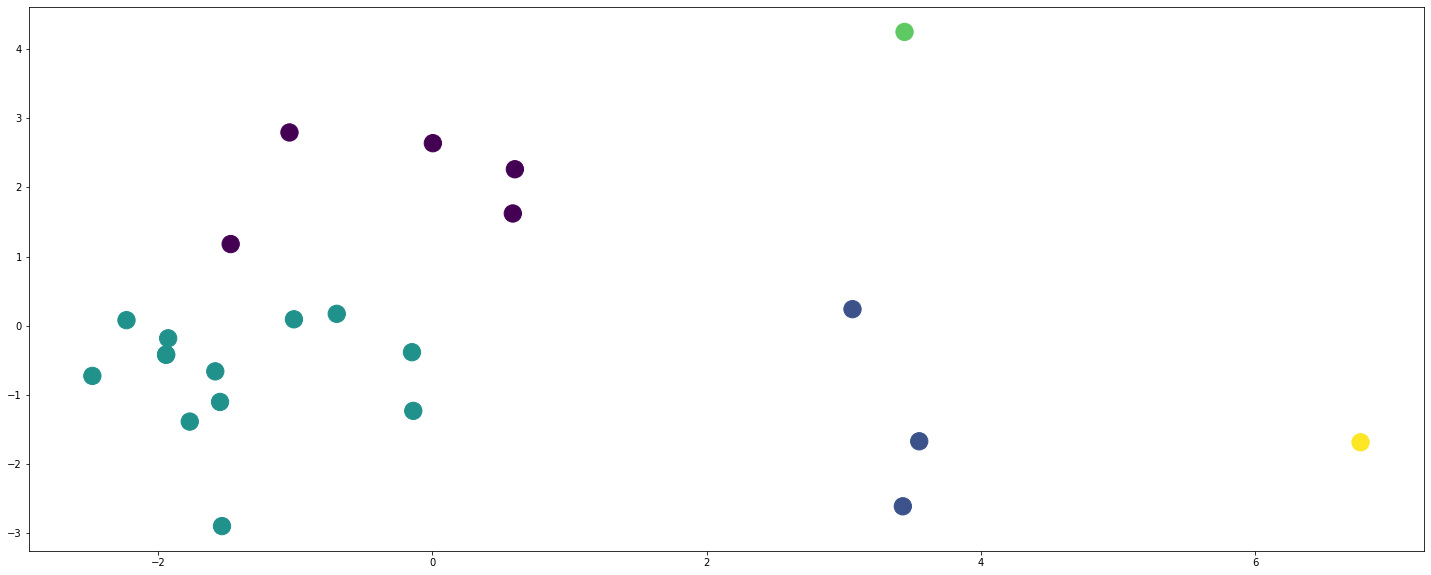

In [83]:
plt.figure(figsize=(25,10))
plt.scatter(mySeries_transformed[:, 0], mySeries_transformed[:, 1], c=labels, s=300)
plt.show()

And again thanks to the clever implementation of ```KMeans``` algorithm by ```sklearn``` team, labels are returned in the same order. Thus, we can use the same code to visualize our cluster in series.

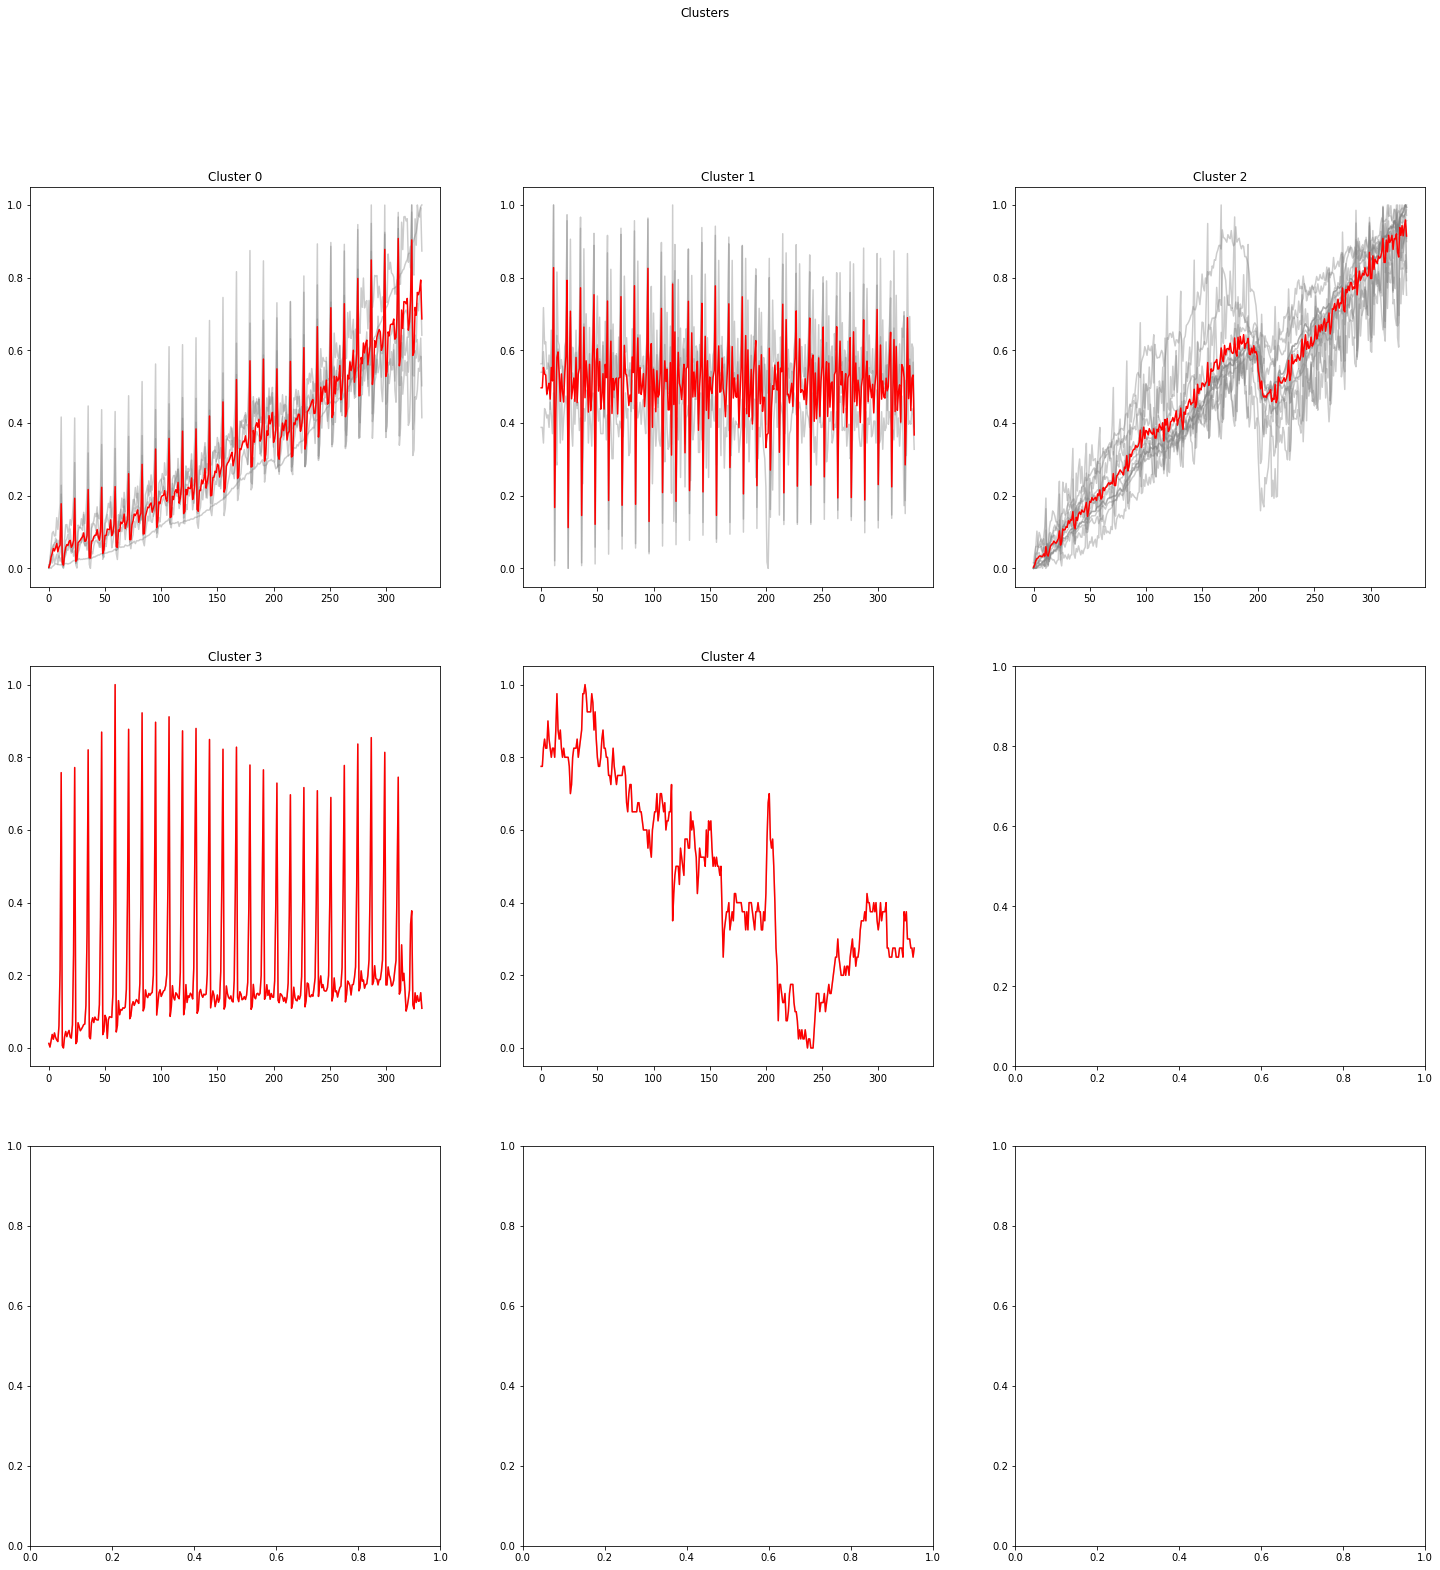

In [84]:
plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(mySeries[i],c="gray",alpha=0.4)
                cluster.append(mySeries[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()

And we can see that now with the ```PCA``` algorithm, our series are much more equally distributed to clusters than before.

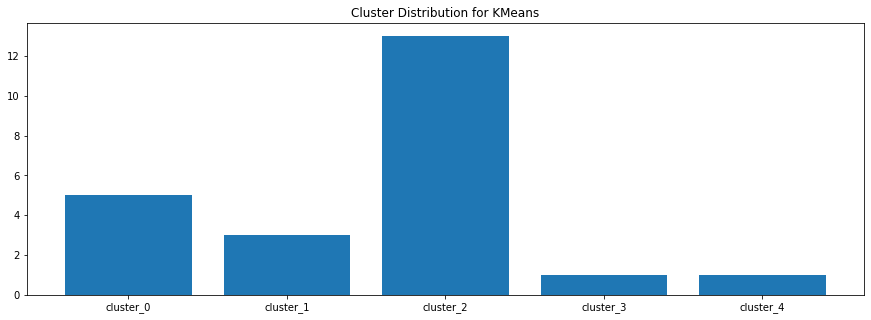

In [85]:
cluster_c = [len(labels[labels==i]) for i in range(cluster_count)]
cluster_n = ["cluster_"+str(i) for i in range(cluster_count)]
plt.figure(figsize=(15,5))
plt.title("Cluster Distribution for KMeans")
plt.bar(cluster_n,cluster_c)
plt.show()

In [86]:
fancy_names_for_labels = [f"Cluster {label}" for label in labels]
pd.DataFrame(zip(namesofMySeries,fancy_names_for_labels),columns=["Series","Cluster"]).sort_values(by="Cluster").set_index("Series")

Cluster
Series                      
MRTSSM4541USS      Cluster 0
MRTSSM45111USN     Cluster 0
MRTSSM4481USN      Cluster 0
MRTSSM7221USN      Cluster 0
MRTSSM4453USN      Cluster 0
RETAILMPCSMSA      Cluster 1
MRTSMPCSM4400CUSN  Cluster 1
RETAILMPCSMNSA     Cluster 1
MRTSSM44111USN     Cluster 2
MRTSSM44611USN     Cluster 2
RETAILSMNSA        Cluster 2
MRTSSM444USS       Cluster 2
MRTSSM44000USS     Cluster 2
MRTSSM44112USN     Cluster 2
MRTSSM4413USS      Cluster 2
RETAILSMSA         Cluster 2
MRTSSM44X72USS     Cluster 2
RETAILIMSA         Cluster 2
MRTSSM442USS       Cluster 2
MRTSSM448USS       Cluster 2
MRTSSM442USN       Cluster 2
MRTSSM45112USN     Cluster 3
RETAILIRSA         Cluster 4